In [1]:
# Import des librairies

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split

# Pour créer le modèle

from sklearn.linear_model import Ridge, Lasso, LinearRegression

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.svm import SVR

# Grid Search

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

# StandardScaler

from sklearn.preprocessing import StandardScaler

# Time

import timeit

# Pour le modèle baseline

from sklearn.metrics import r2_score

In [2]:
# Pour préparer la comparaison des différents modèle plus rapidement, 

def create_report(regressor,X,y,grid,data_to_update,random_state = 0,random_search=False,comment=''):
    '''
    Scal les paramètres, fait un train test split, puis fait un grid search et renvoie les performances du modèle + le grid
    regressor : le modèle que l'on veut évaluer
    X : les paramètres non scalé
    y : la target
    grid : les parametres pour le grid search
    data_to_update : un Dataframe qui sera mis à jour avec le nouvelles donnée
    random_state : le random state pour le train test split 0
    return : le grid search fit et un dataframe avec l'evaluation du modèle
    '''
    start_time = timeit.default_timer()
    
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = random_state)

    # On Scale le X_train

    standart_scale = StandardScaler()

    standart_scale.fit(X_train)

    X_train_scaled = standart_scale.transform(X_train)


    X_test_scaled = standart_scale.transform(X_test)
    
    if random_search :
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        search = RandomizedSearchCV(estimator = regressor,scoring = 'r2',\
                                       param_distributions = grid, n_iter = 10, cv = 5,\
                                       verbose=2, random_state=random_state, n_jobs = -1)
        # Fit the random search model
        search.fit(X_train_scaled, y_train)
    else :    
        search = GridSearchCV(regressor, grid, 
                                   scoring = 'r2',
                                   cv = 5,
                                   n_jobs=-1 # paralellize computation
                                  )
        search.fit(X_train_scaled,y_train)
    
    
    
    train_pred = search.best_estimator_.predict(X_train_scaled)
    test_pred = search.best_estimator_.predict(X_test_scaled)
    
    parameter = {'model':[f'{regressor}'],
    'best_params':[search.best_params_],
    'r2_score_cv':[search.best_score_],
    'r2_score_train': [search.best_estimator_.score(X_train_scaled,y_train)],
    'r2_score_test': [search.best_estimator_.score(X_test_scaled,y_test)],
    'mean_res':[np.mean(test_pred-y_test)],
    'std_res':[np.std(test_pred-y_test)],
    'time (s)':[(timeit.default_timer() - start_time)],
    'commentaire':comment
    }
    return search,pd.concat([data_to_update,pd.DataFrame(parameter)],axis=0)

In [3]:
# On récupère la donnée

data_GHE_path = 'donnée_new/data_GHE.csv'

data_GHE = pd.read_csv(data_GHE_path,sep=',',low_memory=False)


In [4]:
data_GHE

,CouncilDistrictCode_3,TotalGHGEmissions,ENERGYSTARScore,NumberofFloors,YearBuilt,NumberofBuildings,PropertyGFATotal,PrimaryPropertyType_Storage,PrimaryPropertyType_Office,PrimaryPropertyType_Medical
0,0,1265.29,76.0,10,1916,1.0,540360,0,0,0
1,0,38.53,95.0,2,1961,1.0,56228,0,0,0
2,0,270.18,75.0,2,1949,1.0,160645,0,0,0
3,0,16870.98,8.0,3,1992,1.0,494835,0,0,0
4,0,31.47,97.0,2,1990,1.0,54986,0,0,0
...,...,...,...,...,...,...,...,...,...,...
996,0,134.80,9.0,2,1929,1.0,24990,0,1,0
997,1,9.24,77.0,3,2015,1.0,45000,0,0,0
998,0,3.50,75.0,1,1952,1.0,13661,0,1,0
999,0,7.79,93.0,1,1960,1.0,15398,0,1,0


In [5]:
y = np.log(data_GHE[data_GHE['TotalGHGEmissions']>0]['TotalGHGEmissions'])
X = data_GHE[data_GHE['TotalGHGEmissions']>0].drop(columns =['TotalGHGEmissions'])

In [6]:
# On crée notre X sans energystarscore

X_no = data_GHE[data_GHE['TotalGHGEmissions']>0].drop(columns =['TotalGHGEmissions','ENERGYSTARScore'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 0)
standart_scale = StandardScaler()

standart_scale.fit(X_train)

X_train_scaled = standart_scale.transform(X_train)


X_test_scaled = standart_scale.transform(X_test)

In [8]:
# On crée le baseline modèle

# Notre modèle prédis systématiquement la moyenne de y_train

mean_baseline = y_train.mean()

prediction_baseline_train = np.full(y_train.shape,mean_baseline)

# On évalue son R2 score

score_base_train = r2_score(y_train,prediction_baseline_train)

prediction_baseline_test = np.full(y_test.shape,mean_baseline)

score_base_test = r2_score(y_test,prediction_baseline_test)

mean_baseline = np.mean(prediction_baseline_test-y_test)
std_baseline = np.std(prediction_baseline_test-y_test)

In [9]:
# On crée le report vide

report = pd.DataFrame({'model': ['Baseline'],'best_params':[''],'r2_score_cv':[''],'r2_score_train':[score_base_train],\
                       'r2_score_test':[score_base_test] ,'mean_res':[mean_baseline],\
                       'std_res':[std_baseline],'time (s)':[''],'commentaire':['']})
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,-2.220446e-16,-0.059685,0.346245,1.417269,,


In [10]:
# Linear Regression

grid = {}
search_1,report = create_report(LinearRegression(),X,y,grid,report,0)
search_1_no,report = create_report(LinearRegression(),X_no,y,grid,report,0,comment='No energyStar')
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,-2.220446e-16,-0.059685,0.346245,1.417269,,
0,LinearRegression(),{},0.379778,3.997010e-01,0.342383,0.185732,1.134208,1.744743,
0,LinearRegression(),{},0.349053,3.680387e-01,0.274833,0.174368,1.194237,1.249287,No energyStar


In [11]:
# Ridge

grid = {'alpha': np.logspace(-3,3,1000)}
search_2,report = create_report(Ridge(),X,y,grid,report,0)
search_2_no,report = create_report(Ridge(),X_no,y,grid,report,0,comment='No energyStar')
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,-2.220446e-16,-0.059685,0.346245,1.417269,,
0,LinearRegression(),{},0.379778,3.997010e-01,0.342383,0.185732,1.134208,1.744743,
0,LinearRegression(),{},0.349053,3.680387e-01,0.274833,0.174368,1.194237,1.249287,No energyStar
0,Ridge(),{'alpha': 24.569164629827903},0.382231,3.986010e-01,0.330802,0.197900,1.142375,1.622136,
0,Ridge(),{'alpha': 26.3281546564802},0.351452,3.669900e-01,0.265386,0.187263,1.200215,0.966099,No energyStar


In [12]:
# Lasso

grid = {'alpha': np.linspace(0.02,0.03,100)}
search_3,report = create_report(Lasso(),X,y,grid,report,0)
search_3_no,report = create_report(Lasso(),X_no,y,grid,report,0,comment='No energyStar')
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,-2.220446e-16,-0.059685,0.346245,1.417269,,
0,LinearRegression(),{},0.379778,3.997010e-01,0.342383,0.185732,1.134208,1.744743,
0,LinearRegression(),{},0.349053,3.680387e-01,0.274833,0.174368,1.194237,1.249287,No energyStar
0,Ridge(),{'alpha': 24.569164629827903},0.382231,3.986010e-01,0.330802,0.197900,1.142375,1.622136,
0,Ridge(),{'alpha': 26.3281546564802},0.351452,3.669900e-01,0.265386,0.187263,1.200215,0.966099,No energyStar
0,Lasso(),{'alpha': 0.03},0.385601,3.956489e-01,0.321407,0.204792,1.149399,0.184373,
0,Lasso(),{'alpha': 0.03},0.354282,3.641034e-01,0.258518,0.195018,1.204719,0.179494,No energyStar


In [13]:
# SVR

grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
search_4,report = create_report(SVR(),X,y,grid,report,0)
search_4_no,report = create_report(SVR(),X_no,y,grid,report,0,comment='No energyStar')
report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,-2.220446e-16,-0.059685,0.346245,1.417269,,
0,LinearRegression(),{},0.379778,3.997010e-01,0.342383,0.185732,1.134208,1.744743,
0,LinearRegression(),{},0.349053,3.680387e-01,0.274833,0.174368,1.194237,1.249287,No energyStar
0,Ridge(),{'alpha': 24.569164629827903},0.382231,3.986010e-01,0.330802,0.197900,1.142375,1.622136,
0,Ridge(),{'alpha': 26.3281546564802},0.351452,3.669900e-01,0.265386,0.187263,1.200215,0.966099,No energyStar
0,Lasso(),{'alpha': 0.03},0.385601,3.956489e-01,0.321407,0.204792,1.149399,0.184373,
0,Lasso(),{'alpha': 0.03},0.354282,3.641034e-01,0.258518,0.195018,1.204719,0.179494,No energyStar
0,SVR(),{'kernel': 'rbf'},0.426938,5.218869e-01,0.360859,0.276636,1.098764,0.247228,
0,SVR(),{'kernel': 'rbf'},0.395403,4.730933e-01,0.316681,0.231835,1.148391,0.24806,No energyStar


In [14]:
# Random Forest

# Number of trees in random forest
# original
#n_estimators = [10,20,30,50]

n_estimators = [20,22,25]

# Number of features to consider at every split

# original
#max_features = ['auto', 'sqrt']

max_features = ['auto']

# Maximum number of levels in tree

# original
#max_depth = [2,3,4]

max_depth = [3]

# Minimum number of samples required to split a node

# original
#min_samples_split = [3, 5, 10]

min_samples_split = [4, 5, 6]

# Minimum number of samples required at each leaf node

# original
#min_samples_leaf = [ 3, 4, 5]

min_samples_leaf = [ 3, 4, 5]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
search_5,report = create_report(RandomForestRegressor(),X,y,random_grid,report,0)

search_5_no,report = create_report(RandomForestRegressor(),X_no,y,random_grid,report,0,comment='No energyStar')


# Pour voir toute la colonne

pd.options.display.max_colwidth = None

report

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,-2.220446e-16,-0.059685,0.346245,1.417269,,
0,LinearRegression(),{},0.379778,3.997010e-01,0.342383,0.185732,1.134208,1.744743,
0,LinearRegression(),{},0.349053,3.680387e-01,0.274833,0.174368,1.194237,1.249287,No energyStar
0,Ridge(),{'alpha': 24.569164629827903},0.382231,3.986010e-01,0.330802,0.197900,1.142375,1.622136,
0,Ridge(),{'alpha': 26.3281546564802},0.351452,3.669900e-01,0.265386,0.187263,1.200215,0.966099,No energyStar
0,Lasso(),{'alpha': 0.03},0.385601,3.956489e-01,0.321407,0.204792,1.149399,0.184373,
0,Lasso(),{'alpha': 0.03},0.354282,3.641034e-01,0.258518,0.195018,1.204719,0.179494,No energyStar
0,SVR(),{'kernel': 'rbf'},0.426938,5.218869e-01,0.360859,0.276636,1.098764,0.247228,
0,SVR(),{'kernel': 'rbf'},0.395403,4.730933e-01,0.316681,0.231835,1.148391,0.24806,No energyStar
0,RandomForestRegressor(),"{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 25}",0.475191,5.206217e-01,0.423010,0.153370,1.065575,0.481053,


In [15]:
# Gradiant Boosting

#Original
#grid = {'n_estimators':np.arange(1,100,1),
#       'max_depth':[2,3,4],
#       'min_samples_split': [3, 5, 10],
#        'max_features' : ['auto', 'sqrt']}
#        'min_samples_leaf' : [ 3, 4, 5]

grid = {'n_estimators':[10,20,30],
       'max_depth':[2],
       'min_samples_split': [5,6,7],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_leaf' : [ 3, 4, 5]}

search_6,report = create_report(GradientBoostingRegressor(),X,y,grid,report,0)
search_6_no,report = create_report(GradientBoostingRegressor(),X_no,y,grid,report,0,comment='No energyStar')
report.reset_index(drop=True)

,model,best_params,r2_score_cv,r2_score_train,r2_score_test,mean_res,std_res,time (s),commentaire
0,Baseline,,,-2.220446e-16,-0.059685,0.346245,1.417269,,
1,LinearRegression(),{},0.379778,3.997010e-01,0.342383,0.185732,1.134208,1.744743,
2,LinearRegression(),{},0.349053,3.680387e-01,0.274833,0.174368,1.194237,1.249287,No energyStar
3,Ridge(),{'alpha': 24.569164629827903},0.382231,3.986010e-01,0.330802,0.197900,1.142375,1.622136,
4,Ridge(),{'alpha': 26.3281546564802},0.351452,3.669900e-01,0.265386,0.187263,1.200215,0.966099,No energyStar
5,Lasso(),{'alpha': 0.03},0.385601,3.956489e-01,0.321407,0.204792,1.149399,0.184373,
6,Lasso(),{'alpha': 0.03},0.354282,3.641034e-01,0.258518,0.195018,1.204719,0.179494,No energyStar
7,SVR(),{'kernel': 'rbf'},0.426938,5.218869e-01,0.360859,0.276636,1.098764,0.247228,
8,SVR(),{'kernel': 'rbf'},0.395403,4.730933e-01,0.316681,0.231835,1.148391,0.24806,No energyStar
9,RandomForestRegressor(),"{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 25}",0.475191,5.206217e-01,0.423010,0.153370,1.065575,0.481053,


In [16]:
# Gradiant Boosting nous donne le meilleur score et n'overfit pas trop. On le choisie donc comme modèle.

train_pred = search_6.best_estimator_.predict(X_train_scaled)
test_pred = search_6.best_estimator_.predict(X_test_scaled)

Text(0.5, 1.0, 'Repartition des résidus')

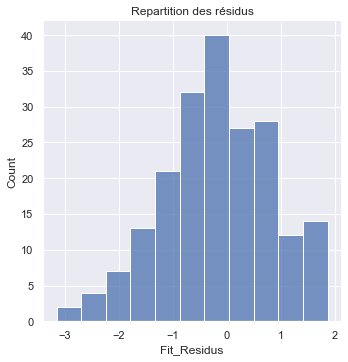

In [17]:
# On plot la répartition des résidus

sns.set()

sns.displot(y_test-test_pred)
plt.xlabel('Fit_Residus')
plt.title('Repartition des résidus')

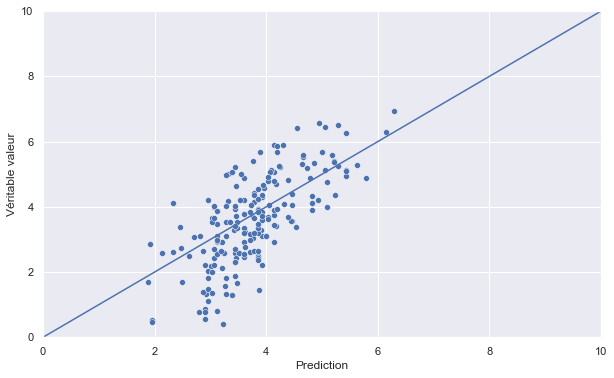

In [18]:
# Plot Prédiction contre valeur réel

fig,ax=plt.subplots(figsize=((10,6)))
sns.scatterplot(x=test_pred, y=y_test)
#sns.scatterplot(x=train_pred, y=y_train)
plt.xlim([0,10])
plt.ylim([0,10])
plt.plot([0,10],[0,10])
plt.xlabel('Prediction')
plt.ylabel('Véritable valeur');

# Ils sont distribués autour de la ligne, mais il y a un petit biais négatif

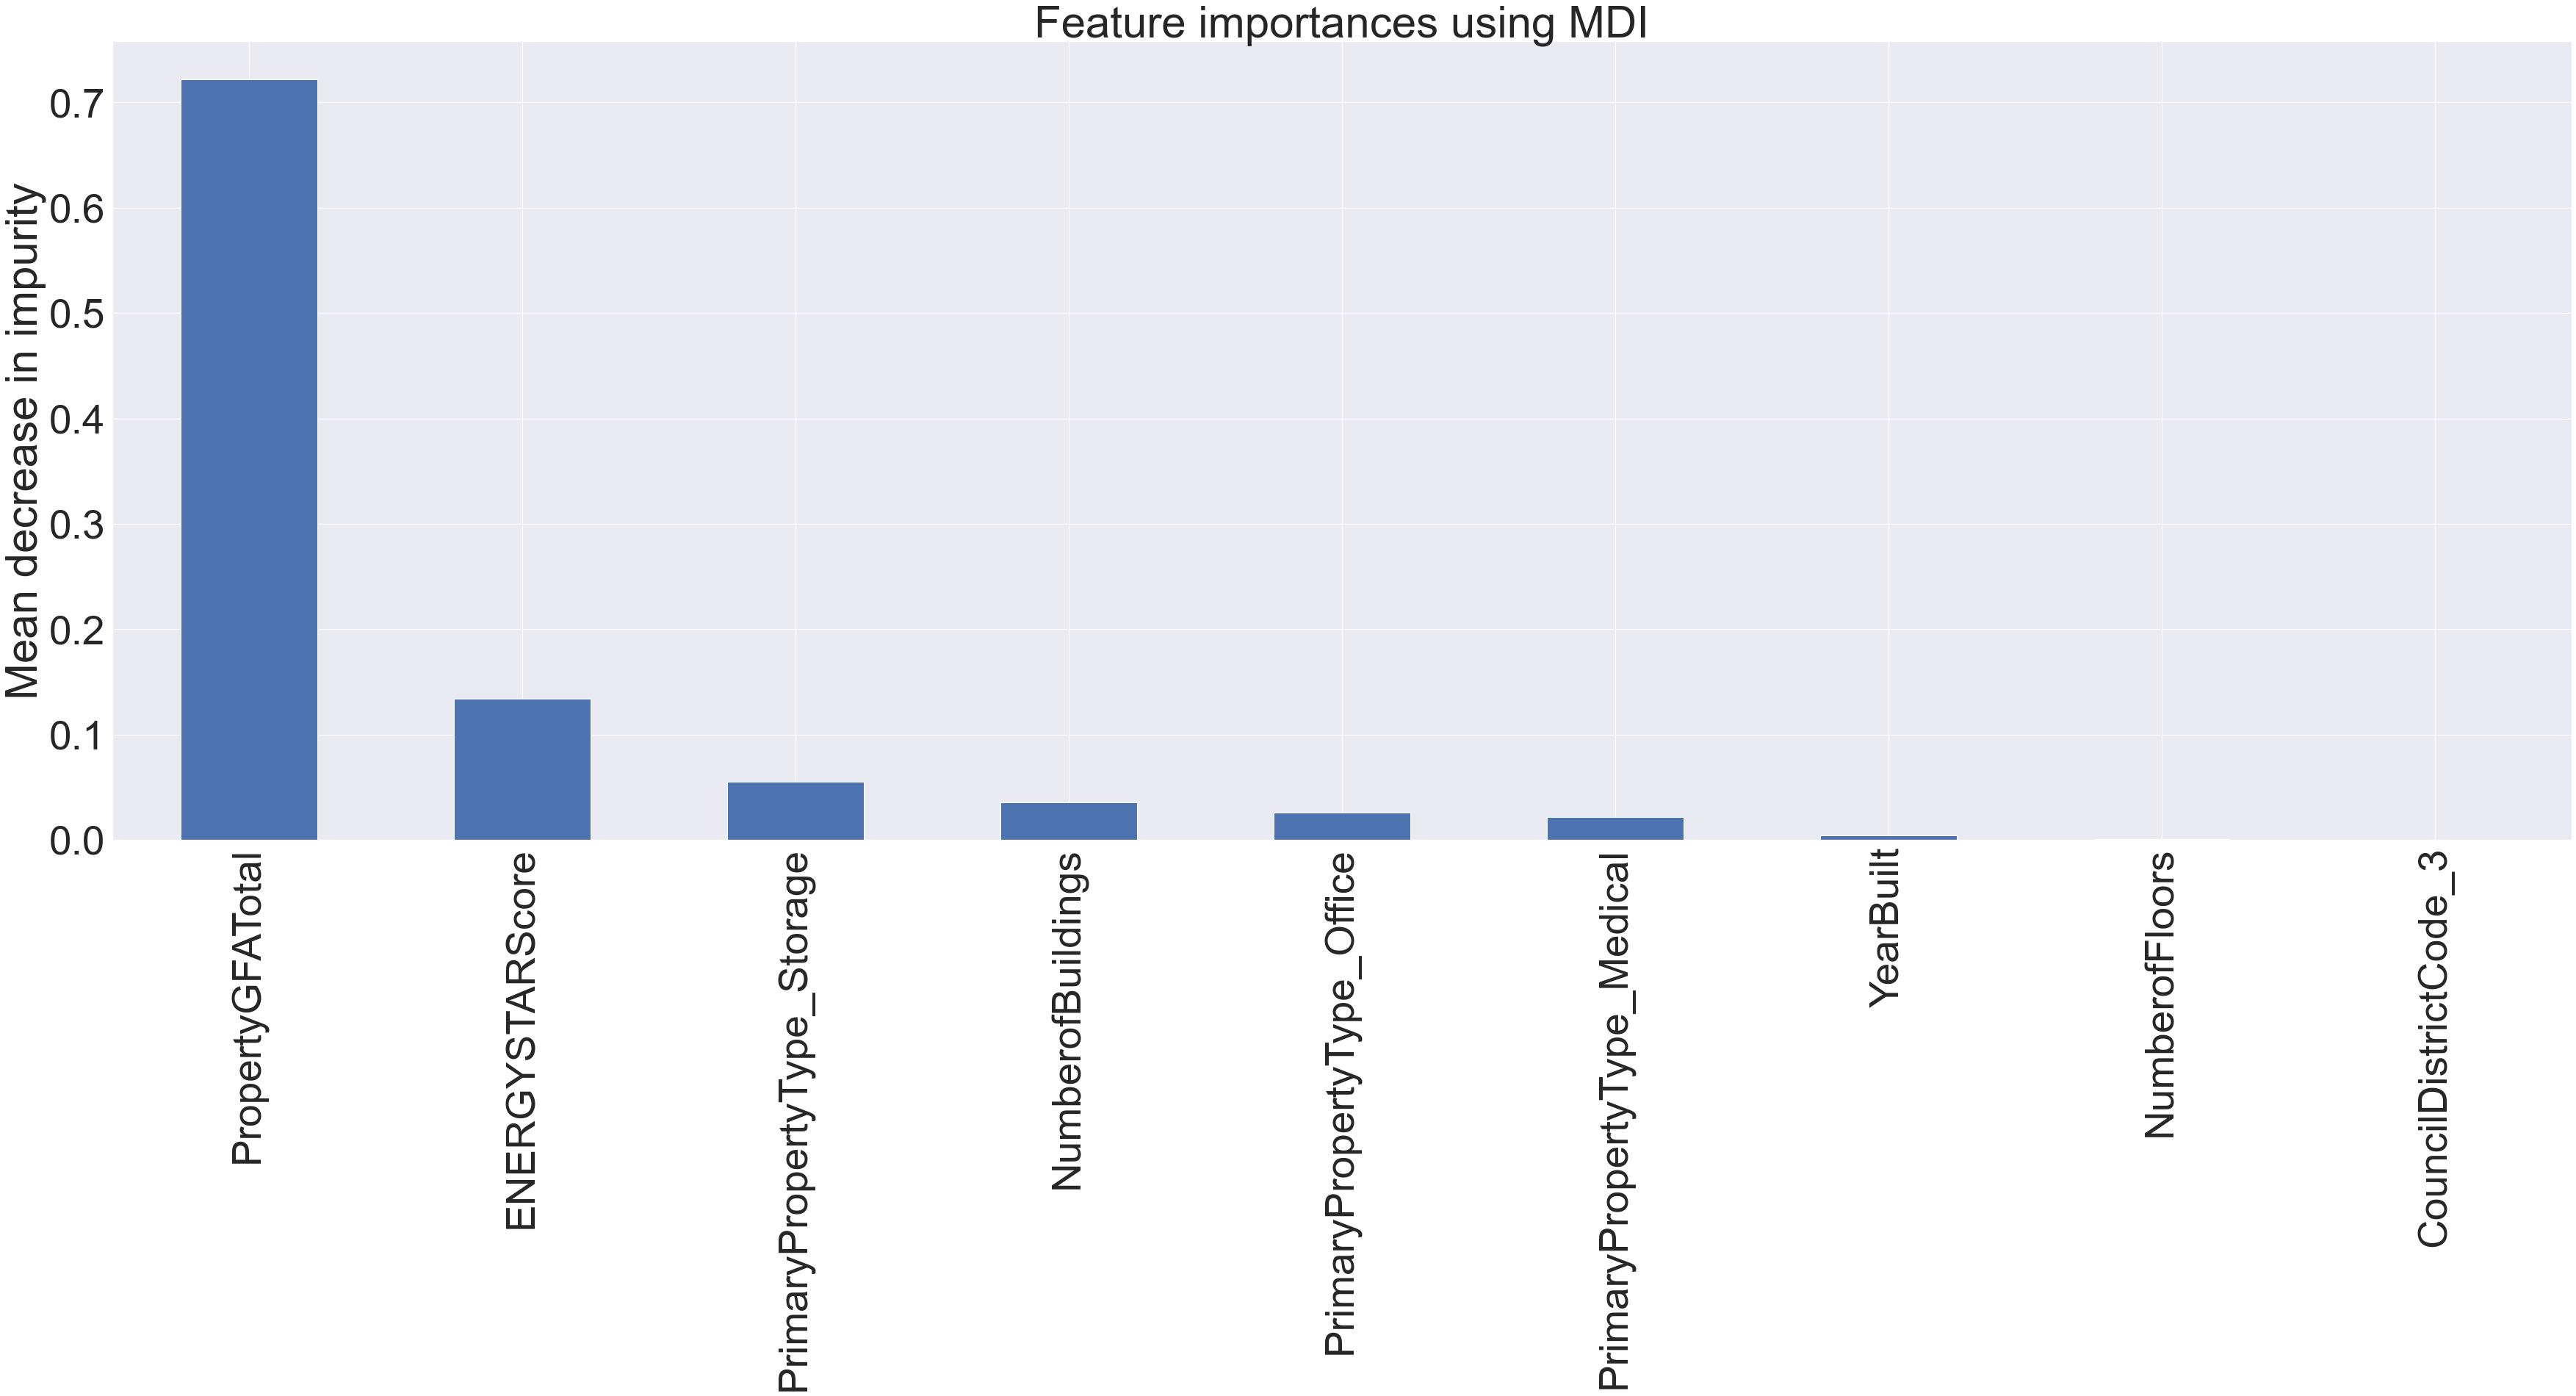

In [19]:
# On observe le feature importance également


sns.set(font_scale = 5,rc={'figure.figsize':(60,20)})

importances  = search_6.best_estimator_.feature_importances_

feature_names = [f"{i}" for i in (X.columns)]
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)

feature_names = [f"feature {i}" for i in (X.columns)]

forest_importances.plot.bar()

plt.title("Feature importances using MDI")
plt.ylabel("Mean decrease in impurity");